In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

FileNotFoundError: [Errno 2] No such file or directory: '/Users/sandervanduin/Desktop/HVA weekly /Digitial Marketing Strategy/DMSteam9/.venv/lib/python3.11/site-packages/numpy/polynomial/hermite_e.py'

# 1. Consumer segment data
- A subscription based service company wants to analyze their customer.
- They collected data from a random sample 300 respondants.
- The data collected contains information: age, gender, income, number of children, whether they own home or not, and currently do they subscribe to the offered service or not.
- The customers are divided into four segments. 
- We will analyze if four consumer segments are statistically different or not using ANOVA.

In [3]:
# Reading data
df = pd.read_csv('http://bit.ly/PMR-ch5')
df.head()

,Segment,age,gender,income,kids,own_home,subscribe
0,travelers,60.794945,male,57014.537526,0,True,False
1,travelers,61.764535,female,43796.941252,0,False,False
2,travelers,47.493356,male,51095.344683,0,True,False
3,travelers,60.963694,male,56457.722237,0,True,True
4,travelers,60.594199,female,103020.070798,0,True,False


## 1.1 One-way ANOVA
Is there a difference between the mean income for the four different consumer segments? 

- $H_0$: There is no difference between the mean income for 4 different consumer segments. <br />
- $H_A$: There is a difference between the mean income for 4 different consumer segments.
- Significance level $\alpha = 0.05$

In [4]:
# Doing some eploratory data analysis (EDA)
# checking number of consumers per segment
df['Segment'].value_counts()

suburb_mix    100
travelers      80
moving_up      70
urban_hip      50
Name: Segment, dtype: int64

In [5]:
#Import necessary python modules for performing ANOVA
import statsmodels.api as sm
import statsmodels.formula.api as smf


#Fitting One-way ANOVA linear model for testing H0 using the 'ols' class in the smf (statsmodels.formula.api) package
income_segment_lm = smf.ols('income ~ Segment', data = df).fit()

#Creating the anova table using the stats.anova_lm method in the sm (statsmodels.api) package
anova_table = sm.stats.anova_lm(income_segment_lm)
print(anova_table)

             df        sum_sq       mean_sq           F        PR(>F)
Segment     3.0  6.008669e+10  2.002890e+10  114.651236  2.794439e-49
Residual  296.0  5.170946e+10  1.746941e+08         NaN           NaN



**Result of One-way ANOVA:** As the $p$-value < 0.05, we reject $H_0$ in favor of $H_A$.

## 1.1.2 Checking for assumptions of one-way ANOVA:
- Generally while performing ANOVA we **must** test for the assumptions! 

The assumptions for one-way ANOVA are:
- *Sample independence*: each sample has been drawn independently of the other samples
- *Normality*: each sample is taken from a normally distributed population 
- *Equal variance*: the variance of data within the different groups (in this case consumer segment) should be the same

### Testing for normality
- *Compute the residuals*: the residuals are computes by simply subtracting from the measurements of each segment the mean value for that segment and dividing by the standard deviation of each segment.
- We will use inbuild residual function from the 'ols' class of the 'statsmodels.formula.api' package to compute the residuals
- use a Q-Q plot against standard normal distribution

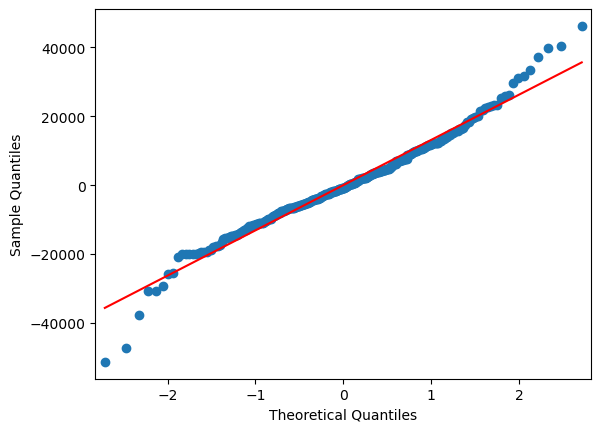

In [6]:
# using the inbuild residual function from the 'ols' class
residuals = income_segment_lm.resid
# using statsmodels.api (sm) qqplot method
sm.qqplot(residuals, stats.norm, line = 's')
plt.show()

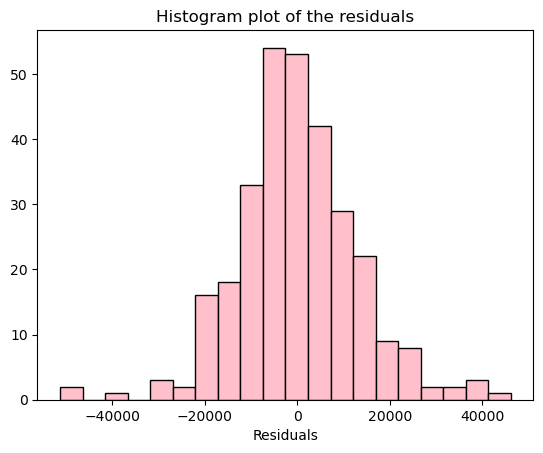

In [7]:
# Histogram plot of the residuals
plt.hist(residuals, bins = 20, facecolor = 'pink', edgecolor = 'k')
plt.title('Histogram plot of the residuals')
plt.xlabel('Residuals')
plt.show()

### **Q1) What would you conclude from the qq plot and the histogram plot of the residuals?**

### Equal variance: Visually analyzing the data first for testing equal variance

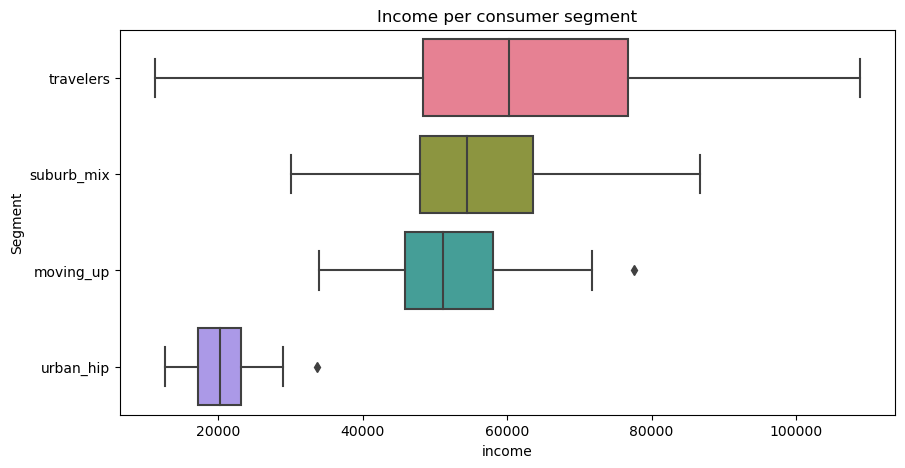

In [8]:
# First we visually analyze the four segments income using a boxplot
fig = plt.subplots(figsize=(10,5))
sns.boxplot(x = 'income', y = 'Segment', data= df, palette="husl")
plt.title('Income per consumer segment')
plt.show()

### **Q2) What would you conclude from the boxplots above?**

### Equal variance: hypothesis testing
Generally two tests can be used to test if all samples come from populations with equal variances:
- **Bartlett’s test**: tests the null hypothesis that all input samples are from populations with equal variances for normal population. 
Documentation: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bartlett.html
-  **Levene test**: tests the null hypothesis that all input samples are from populations with equal variances for non-normal population.
Documentation: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html#scipy.stats.levene

In [9]:
# Getting data for each segment
seg_travellers = df[df['Segment'] =='travelers']['income'].values
seg_suburb_mix = df[df['Segment'] == 'suburb_mix']['income'].values
seg_moving_up = df[df['Segment'] == 'moving_up']['income'].values
seg_urban_hip = df[df['Segment'] == 'urban_hip']['income'].values

### As we have seen from the residual q-q plot that the data is almost normally distributed, we use the Bartlett's test. However, if one is not convinced they can use the Levene's test for equal variance.

In [10]:
# Performing the Barlett's test
statistic_barlette, p_barlette = stats.bartlett(seg_travellers, seg_suburb_mix, seg_moving_up, seg_urban_hip)

if p_barlette < 0.05:
    print('Null hypothesis that all input samples are from populations with equal variances is REJECTED')
else:
    print('We FAIL to REJECT the null hypothesis that all input samples are from populations with equal variances')

Null hypothesis that all input samples are from populations with equal variances is REJECTED


In [11]:
# Performing the Levene's test
statistic_levene, p_levene = stats.levene(seg_travellers, seg_suburb_mix, seg_moving_up, seg_urban_hip)
if p_levene < 0.05:
    print('Null hypothesis that all input samples are from populations with equal variances is REJECTED')
else:
    print('We FAIL to REJECT the null hypothesis that all input samples are from populations with equal variances')

Null hypothesis that all input samples are from populations with equal variances is REJECTED


### Given that the segments do not have equal variances and neither are the sample size in each group are same, we cannot use the parametric one-way ANOVA testing. We need to resort to non-parametric methods. 

## 1.2 Non parametric method for one-way ANOVA:  Kruskal-Wallis H test
- The observations are assumed to be independent, but no particular distributional form, such as the normal, is assumed.
- The Kruskal-Wallis H-test tests the null hypothesis that the population median of all of the groups are equal.
- The H-statistic follows a $\chi^2$ distribution with $I-1$ *dof*, where $I$ is number of groups/segments.
- Kruskal-Wallis H test is **one-tailed test** as H-statistic follows a $\chi^2$ distribution.
- The test works on 2 or more independent samples, which may have different sizes.
- Due to the assumption that the test statistic H has a chi square distribution, the number of samples in each group must not be too small. 
- A typical rule is that each group must have at least 5 measurements.

In [12]:
alpha = 0.05
test_stat, p_val = stats.kruskal(seg_travellers, seg_urban_hip, seg_suburb_mix, seg_moving_up)
print('The p-value for Kruskal-Wallis H test is:', p_val)

if p_val <= alpha:
    print('We reject the null hypothesis that the population median of all of the groups are equal at significance level = {}'.format(alpha))
else:
    print('We fail to reject the null hypothesis that the population median of all of the groups are equal at significance level = {}'.format(alpha))

The p-value for Kruskal-Wallis H test is: 3.6506928970340715e-28
We reject the null hypothesis that the population median of all of the groups are equal at significance level = 0.05


### Post hoc method: Bonferroni's test
- One-way ANOVA tells us that the means of different groups are all equal or not equal, but the test gives no information about how they differ, in particular about which pairs are significantly different.  In reallife cases we are more inserted in knowing which pairs of groups are different.


- **Bonferroni's test**: Performs pair-wise $t$-tests for $k$ null hypoethesis and gaurantees an overall Type I error rate of $\alpha$ by testing each null
hypothesis at a significance level of $\alpha/k$.

- The output from this method tells us whether to reject or not the pair-wise t-tests.
- Module documentation: https://www.statsmodels.org/stable/generated/statsmodels.sandbox.stats.multicomp.MultiComparison.allpairtest.html#statsmodels.sandbox.stats.multicomp.MultiComparison.allpairtest
- ### **Q3) What is the default $\alpha$ value given in the documentation? Do you want to change it? Justify your answer**

In [13]:
from statsmodels.stats.multicomp import MultiComparison

# Creating a class instance
mc = MultiComparison(df['income'], df['Segment'])

#Applying the .allpairtest class method to perform Bonferroni's test
bonferroni = mc.allpairtest(stats.ttest_ind, method='b')
print(bonferroni[0])

Test Multiple Comparison ttest_ind 
FWER=0.05 method=b
alphacSidak=0.01, alphacBonf=0.008
  group1     group2     stat   pval  pval_corr reject
-----------------------------------------------------
 moving_up suburb_mix -2.3583 0.0195     0.117  False
 moving_up  travelers -4.1198 0.0001    0.0004   True
 moving_up  urban_hip 22.8021    0.0       0.0   True
suburb_mix  travelers -2.9544 0.0036    0.0213   True
suburb_mix  urban_hip  21.399    0.0       0.0   True
 travelers  urban_hip 14.4417    0.0       0.0   True
-----------------------------------------------------


### **Q4) What is FWER is the above result. See if you can find it from the module documentation.**
### **Q5) Why is alphacBonf=0.008 in the above result? Think about how many pair-wise t-test are being undertaken and the initial $\alpha$ value.**

## 1.2 Two way ANOVA

### Now, we want to know how the income varies per customer segment if they are home owners or not?
- First we will do some EDA.
- We will perform the EDA to see how income varies per segment and also if the customer owns a home or not.

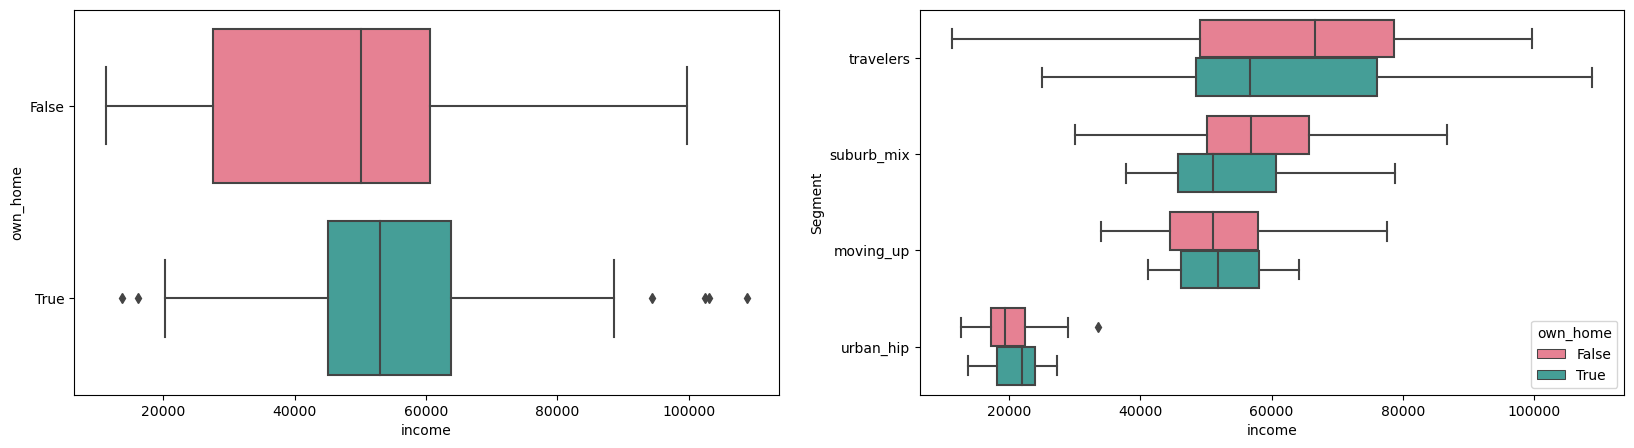

In [14]:
#EDA 
#First boxplot: to check how income varies if a customer owns home or not.
#Second boxplot: to chech how income varies within each customer segment based on if they own a home or not.
fig, axes = plt.subplots(1,2, figsize = ((20,5)))
sns.boxplot(x = 'income', y = 'own_home', data= df, palette="husl", orient='h', ax = axes[0])
sns.boxplot(x = 'income', y = 'Segment', hue = 'own_home', data= df, palette="husl", ax = axes[1])
plt.show()

### **Q6) What can you conclude from the above EDA?**

In [15]:
# Two way ANOVA with interaction
formula = 'income ~ Segment*own_home'
income_segment_home_lm = smf.ols(formula, data = df).fit()
twoWay_anova_table = sm.stats.anova_lm(income_segment_home_lm)
print(twoWay_anova_table)

                     df        sum_sq       mean_sq           F        PR(>F)
Segment             3.0  6.008669e+10  2.002890e+10  113.502010  9.839888e-49
own_home            1.0  4.000708e+07  4.000708e+07    0.226717  6.343252e-01
Segment:own_home    3.0  1.422781e+08  4.742603e+07    0.268759  8.479014e-01
Residual          292.0  5.152717e+10  1.764629e+08         NaN           NaN


### From the result above what can you say:
### **Q7) Is there significant interaction (at level $\alpha = 0.05$) between home ownership and customer segment? In other words, could it be that home ownership is related to income in some segment and not in others? Remember the null hypothesis for AB interactions**? </br>
### **Q8) Which variable 'segment' and/or 'own_home' is a significant predictor of income differences (at significance level $\alpha = 0.05$)?**

## Interaction plots 

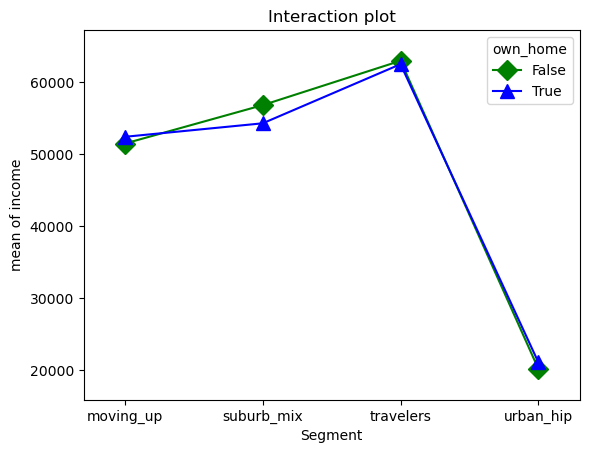

In [16]:
# Following is the code to plot interaction plots
from statsmodels.graphics.factorplots import interaction_plot

fig = interaction_plot(df['Segment'], df['own_home'], df['income'], colors=['green','blue'], markers=['D','^'], ms=10)
plt.rcParams["figure.figsize"] = (10,5)
plt.title('Interaction plot')
plt.show()

## From the plot above:
### **Q9) would you say there is significant interaction between 'segment' and 'own_home' categorical variables?** </br>
### **Q10) is the interaction plot in agreement with the results from the two-way ANOVA table we got? Elaborate why or why not?**

# 2. Iris data

- Compare the mean of 'sepal_length' for the different species in the iris dataset.
- What is $H_0$ and $H_A$? 
- Before doing ANOVA what kind of exploratory data analysis (EDA) will you do? Maybe plot some histogram or boxplot? What do you conclude from these plots?
- Which ANOVA test will you undertake?
- What is your final conclusion from the ANOVA testing? 
- Write clear codes to test all the ANOVA assumptions. Make some conclusions on if the assumptions are satisfied or not.
- While testing the ANOVA assumptions make visualizations similar to what is shown in this notebook above.